In [11]:
import torch
import librosa
import librosa.display
import numpy as np
import scipy.signal
from scipy.io.wavfile import read,write
import math
import pandas as pd
import os
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
import argparse
import sox
import IPython
import pickle

def magphase_to_spect(mag,phase,mean,std):
    """
    A function which converts the mag data and phase data to a spectogram.
    
    mag <np matrix>: a numpy matrix specifying the magnitude data of a spectogram
    phase <np matrix>: a complex valued numpy matrix specifying the phase data of a spectogram
    mean <float>: a singular valued float which specifies the mean of the mag before normalization
    std <float>: a singular valued float which specifies the std of the mag before normalization
    
    """
    print(phase.shape,mag.shape)
    mag = mag[:phase.shape[0],:phase.shape[1]]
    print(mean,std)
    mag = mag*std + mean
    mag = np.expm1(mag) 
    D = np.multiply(mag,phase)
    return D

def spect_to_aud(D,hop_length,win_length,window,sample_rate,save_path,tfm):
    """
    A function which converts a spectogram into an audio file and stores at a specified location.
    
    D <np matrix>: a numpy matrix specifying the spectogram including mag and phase of the audio.
    hop_length <float>: a singular valued float specifying the hop length for the inverse stft
    window <scipy argument>: the type of window to be utilized for inverse i stft.
    sample_rate <integer>: a singular valued integer which specifies the sample rate for the audio
    save_path <string>: a string value specifying the path to save the audio file
    tfm <sox tfm object>: a sox transformer object with specified details of how to build the audio.
    
    """
    reconstructed_audio = librosa.istft(D,hop_length=hop_length,win_length=win_length,window=window)
    tfm.build_file(input_array=reconstructed_audio,sample_rate_in=sample_rate,output_filepath=save_path)
    
def load_audio(path):
    
    """
    A function which loads the audio from a particular path in the required format.
    
    path <string>: a string value specifying the path to retrieve the audio file
    
    """
    
    sample_rate, sound = read(path)
    sound = sound.astype('float32') / 32767  # normalize audio
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    sound = 2*((sound - sound.min()) / (sound.max() - sound.min())) - 1
    return sound

## Loading the Meta Data

Loading all the components such as mag data, phase data, mean, std, window size, window etc. These are then utilized further in the cells to build an audio file

In [18]:
mag  = torch.load("/media/data_dump/hemant/hemant/v2_asr/Robust_ASR/single_visual/representations/d.pth")
with open("/media/data_dump/hemant/hemant/v2_asr/Robust_ASR/single_visual/meta/dev_other-700-122868-0023.pickle","rb") as handle:
    metadata = pickle.load(handle)
song_name = "dev_other-700-122868-0023"
forg_mag = mag[0][2]
enc_mag = mag[0][1]
inp = mag[0][0]

enc_mag = enc_mag.squeeze().numpy()[:metadata["phase"].shape[0],:metadata["phase"].shape[1]]
forg_mag = forg_mag.squeeze().numpy()[:metadata["phase"].shape[0],:metadata["phase"].shape[1]]
inp_mag = inp.squeeze().cpu().numpy()[:metadata["phase"].shape[0],:metadata["phase"].shape[1]]

# print(enc_mag.shape)
# print(forg_mag.shape)
# print(inp.shape)
# print(metadata["phase"].shape)

phase =metadata["phase"]
mean=metadata["mean"]
std = metadata["std"]
phase,mean,std

window_stride = 0.01
window_size = 0.02
sample_rate = 16000
save_path = "new_wav/"
window = scipy.signal.hamming
n_fft = int(sample_rate * window_size)
win_length = n_fft
hop_length = int(sample_rate * window_stride)

(161, 141)
(161, 141)
torch.Size([1, 1, 161, 141])
(161, 141)


## Metadata to Audio File 

In [3]:
D = magphase_to_spect(enc_mag,phase,mean,std)
tfm = sox.Transformer()
tfm.convert(samplerate=16000,bitdepth=16,n_channels=1)
spect_to_aud(D,hop_length,win_length,window,sample_rate,save_path+song_name+".wav",tfm)

output_file: new_wav/dev_other-700-122868-0023.wav already exists and will be overwritten on build


(161, 141) (161, 141)
0.26131772994995117 0.4405592978000641


## Specifying Path to Original Audio and Reconstructed Audio

In [4]:
original_audio = "/media/data_dump/hemant/rachit/dataset/downloaded_Data/librispeech/LibriSpeech/wav/dev_other-700-122868-0023.wav"
reconstructed_audio = "/media/data_dump/hemant/rachit/Robust_ASR/visualization/aud2spec2aud/wav/inp/dev_other-700-122868-0023.wav"

## Listening to the Original Audio

In [5]:
IPython.display.Audio(original_audio)

## Listening to the Reconstructed Audio

In [6]:
IPython.display.Audio(reconstructed_audio)

## Plotting Original and Reconstructed Audio Together

Note that Reconstructed Audio is in Blue whereas Original Audio is in orange

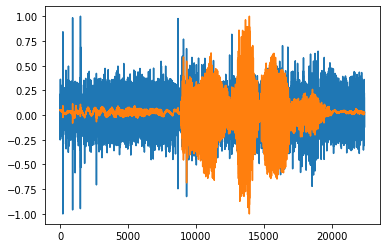

In [7]:
original_audio = load_audio(original_audio)
reconstructed_audio = load_audio(reconstructed_audio)

plt.plot(reconstructed_audio)
plt.plot(original_audio)

## STFT for Original and Reconstructed Audio

In [8]:
D_org = librosa.stft(original_audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
D_rec = librosa.stft(reconstructed_audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
reconstructed, phase = librosa.magphase(D_rec)
original, phase = librosa.magphase(D_org)

## Plotting Original Audio Spectogram

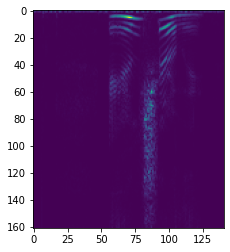

In [9]:
plt.imshow(original)

## Plotting Reconstructed Audio Spectogram

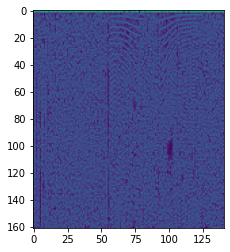

In [10]:
plt.imshow(reconstructed)